#  Lab 2 Instructions

In this notebook, we will learn how to do classification of MNIST handwritten digits using TensorFlow 2. The notebook contains all the info that you need to understand the basic mechanism of the classification theory. 

Your are free to tweak the hyper-parameters (including number of hidden units, number of hidden layers, learning rate, num of iterations and so on) to improve the performance of the model. The final block of the code computes the prediction accuracy of the model on the testing set, please do not change this block.

Make sure that your final submission is a notebook that can be run from beginning to end, and you should print out the accuracy at the end of the notebook (i.e. be sure to run the last block after training). It is in fact possible to achieve >98% accuracy on this dataset with a more complex neural network architecture and careful tuning of hyper-parameters. **Your grade will depend on the final prediction accuracy**. However, if you tweak the evaluation code to report false result, you will receive no credit for this assignment.

In [36]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

## Classification using TensorFlow 2

In the introduction notebook, we walked through how to solve a supervised learning regression problem (i.e. where the labels are continuous values) from scratch. Now, you will build a model that solves a classification problem (i.e. where the labels are discrete values). We will use the MNIST hand written digit dataset, a toy benchmark for image classification models. Let's first load the dataset via the TensorFlow 2 API.

### Dataset
Here $X_{train},Y_{train}$ denote the training data and $X_{test},Y_{test}$ denote the testing data. We train the model on training set and evaluate its performance on testing set (to evaluate potential under-fitting or over-fitting). As can be seen below, $X_{train}$ contains $60000$ examples with $28 \times 28 $ pixels. $Y_{train}$ contains $60000$ corresponding examples with $10$ classes. 

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")


train_dataloader = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(64)
test_dataloader = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

print(len(x_train), len(x_test))

60000 10000


Shape of x:  (28, 28, 1)
Label:  5


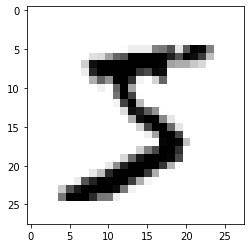

In [4]:
x, y = x_train[0], y_train[0]
print("Shape of x: ", x.shape)
print("Label: ", y)

plt.imshow(x.squeeze(), cmap='gray_r');

Let's look at a bunch of samples!

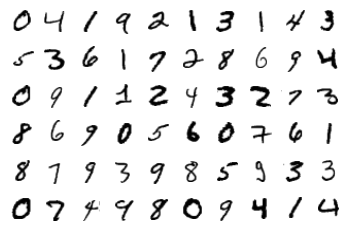

In [5]:
figure = plt.figure()
num_of_images = 60
for i in range(1, num_of_images + 1):
    x, y = x_train[i], y_train[i]
    plt.subplot(6, 10, i)
    plt.axis('off')
    plt.imshow(x.squeeze(), cmap='gray_r')

### Model
You are responsible for defining the model f(x) = y, where x is an image and y is the digit found in the image. We provide one way to do this, but you will need to explore different model architectures and training strategies to get sufficient performance: 

The shape of any image x is 28x28. We can reshape the image so it is instead a vector of length 28*28 = 784. Then, we can use the methods described in the introduction notebook to map a 784-dimensional vector to a 10-dimensional vector of probabilities. The digit in the image will then correspond to the index of the highest probability entry in the predicted 10-dimensional vector.

In [25]:
model = tf.keras.models.Sequential([
          tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
          tf.keras.layers.MaxPool2D((2, 2)),
          tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
          #tf.keras.layers.MaxPool2D((2, 2)),
          tf.keras.layers.Flatten(),
          #tf.keras.layers.Dense(64,activation = "relu"),
          tf.keras.layers.Dense(10),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_3 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                77450     
Total params: 96,266
Trainable params: 96,266
Non-trainable params: 0
_________________________________________________________________


In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(784, activation = "relu"),
          tf.keras.layers.Dense(30, activation = "relu"),
          tf.keras.layers.Dense(30, activation = "relu"),
          tf.keras.layers.Dense(10),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

Unlike regression, where the predicted output y is a scalar in $\mathbb{R}$, in classification the model outputs logits or scores, one for each class. In our problem, there are 10 classes so the output of f(x) is a 10-dimensional vector of scores. 

In order to convert these scores to probabilities, we can simply normalize. Typically, the softmax operation is used to compute probabilties from logits or scores. After computing the prediction y = f(x), which is a 10-dimensional, we can compute the probability vector p:

$$p_i = \frac{e^{y_i}}{\sum_{j=1}^{10} e^{y_j}}, i=1,\ldots, 10, \text{ or } p=softmax(y)$$

In [12]:
def probabilties_from_scores(y):
    f = tf.nn.softmax
    p = f(y)
    return p

### Loss

For $K$ classes, our labels y in the dataset will take on an integer value between [0,K]. We must convert these values to one-hot representations. For example, when $K=3$, y = 1 as a one-hot vector would be $[1,0,0]$ to represent the first class. If the model predicts a probability $p\in\mathbb{R}^K$ for this training instance, the loss function is

$$L = - \sum_{i=1}^K y_i \log p_i$$

Therefore, in the example where y = 1, L = - probability of the first entry since the one-hot vector is [1, 0, 0]. The loss function motivates assigning high probability to true classes and low probability otherwise.

In [13]:
def loss(y_hat, y):
    # y_hat has shape (N, 10) for 10 classes, y has shape (N,) 
    f = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    return f(y, y_hat)

### Optimization
Now we perform stochastic gradient descent on the model. We can first try to evaluate the model's initial performance on the testing dataset as a comparison.

In [14]:
def evaluate(dataloader, model, log=False):
    correct_count, total_count = 0, 0
    for images_batch, labels_batch in dataloader:
        images = tf.reshape(images_batch, (images_batch.shape[0],28*28))
        scores = model(images)
        probabilities = probabilties_from_scores(scores)
        pred_label = tf.math.argmax(probabilities, axis=1)
        correct_count += tf.reduce_sum(tf.cast(pred_label == tf.cast(labels_batch, tf.int64), tf.int64)).numpy()
        total_count += labels_batch.shape[0]

    if log:
        print("Number Of Images Tested =", total_count)
        print("Model Accuracy =", (correct_count/total_count))
    
    return (correct_count/total_count)

#### Training Loop
Optimize the model to improve the prediction accuracy.

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=5, 
                    validation_data=(x_test, y_test))

Epoch 1/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2787 - accuracy: 0.9156 - val_loss: 0.0445 - val_accuracy: 0.9862
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0420 - accuracy: 0.9871 - val_loss: 0.0413 - val_accuracy: 0.9864
Epoch 3/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0288 - accuracy: 0.9916 - val_loss: 0.0323 - val_accuracy: 0.9893
Epoch 4/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0206 - accuracy: 0.9933 - val_loss: 0.0340 - val_accuracy: 0.9898
Epoch 5/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0158 - accuracy: 0.9952 - val_loss: 0.0365 - val_accuracy: 0.9884


#### Evaluation 
Test the model's accuracy on the unseen test dataset.

313/313 - 0s - loss: 0.0365 - accuracy: 0.9884


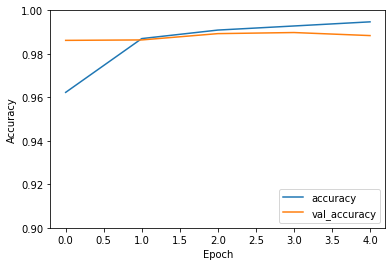

In [30]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

Shape of x:  (28, 28, 1)
Label:  0


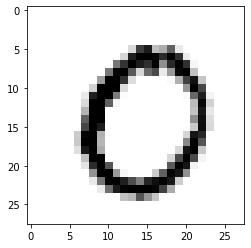

In [41]:
x, y = x_test[101], y_test[101]
print("Shape of x: ", x.shape)
print("Label: ", y)

plt.imshow(x.squeeze(), cmap='gray_r');

In [53]:
np.argmax(probabilties_from_scores(model.predict(x_test))[101])

0

In [44]:
#another way to write this
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(x_test)

In [55]:
np.argmax(predictions[101])

0

See that the model's performance improves from 10% accuracy to about 92%. For this simple task, getting an accuracy of 92% is not quite impressive. Try to tweak the parameters and neural network architecture to get better predictions! You should be able to get >= 98% test accuracy.